0.009523809523809525
dist in delete redundant
1.1102230246251565e-16
Deleting point
[0.41000000000000014, 1.0]
Because same as point
[0.41000000000000003, 1.0]
dist in delete redundant
1.1102230246251565e-16
Deleting point
[0.41000000000000014, -1.0]
Because same as point
[0.41000000000000003, -1.0]
dist in delete redundant
1.1102230246251565e-16
Deleting point
[0.3900000000000001, 1.0]
Because same as point
[0.39, 1.0]
dist in delete redundant
1.1102230246251565e-16
Deleting point
[0.3900000000000001, -1.0]
Because same as point
[0.39, -1.0]
Coordinates of Reflected Point
[[0.59, 0], [-1.4100000000000001, 0], [0.41000000000000003, 1.0], [0.41000000000000003, -1.0], [-1.5899999999999999, 0], [0.59, 1.0], [0.59, -1.0], [2.41, 0], [-1.4100000000000001, 1.0], [-1.4100000000000001, -1.0], [0.41000000000000003, -2.0], [0.41000000000000003, 2.0], [2.59, 0], [-1.5899999999999999, 1.0], [-1.5899999999999999, -1.0], [0.59, -2.0], [0.59, 2.0], [-3.41, 0], [2.41, 1.0], [2.41, -1.0], [-1.410000000

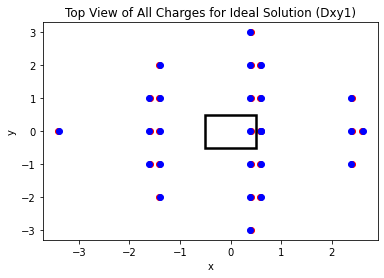

Still running...
tan1.shape
(106, 106)
ph1.shape
(106, 106)
len(yline)
106
Multiple linecut plots (like omega sweep but over full lattice):
ph1 (multiple linecuts with Dxy1) plot
106
106


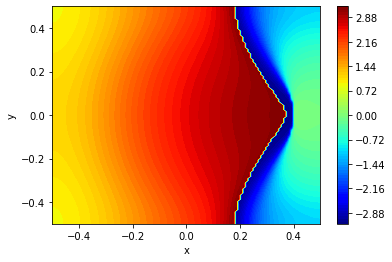

unwrapped ph1 plot


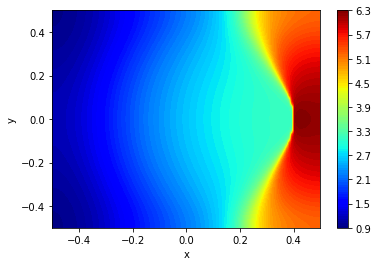

ph2 (multiple linecutes with Dxy2) plot


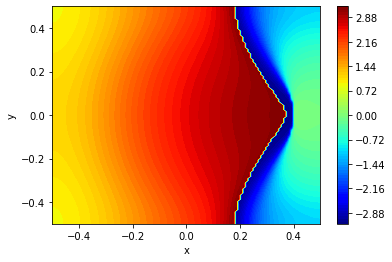

unwrapped ph2 plot


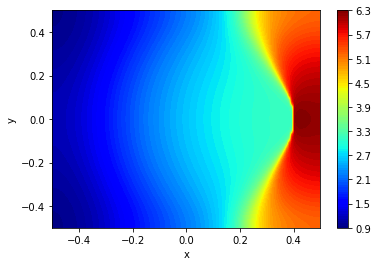

phdif plot


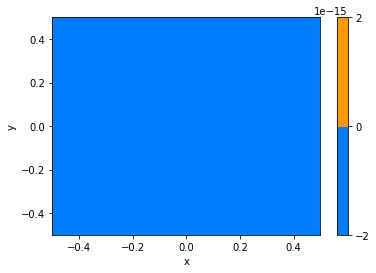

unwrapped phdif plot


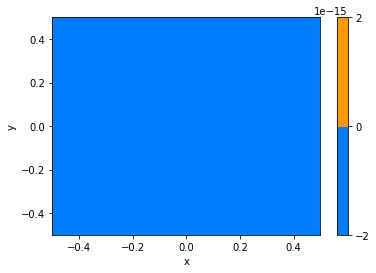

unwrapped phdif plot with cutoff 1


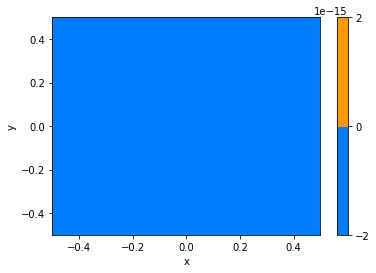

unwrapped phdif plot with cutoff 2


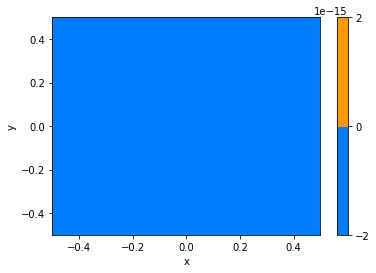

unwrapped phdif plot with cutoff 3


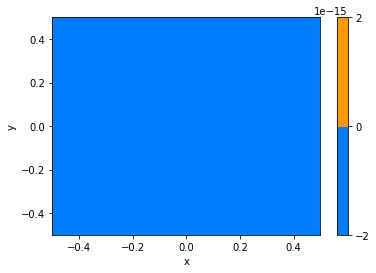

Linecuts at x = 0.45 (value used in omega sweep)


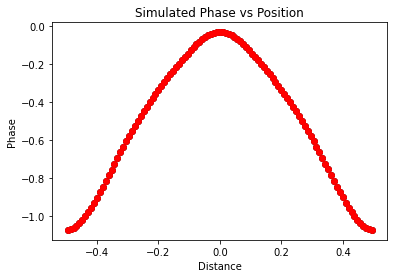

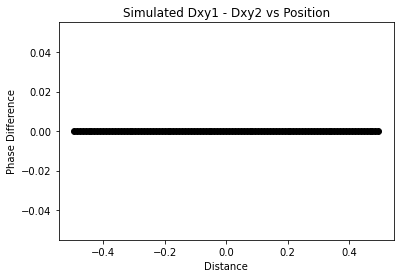

Full lattice solve plots:
Ideal Dxy1


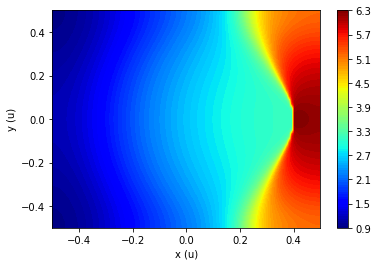

Simulated Dxy1


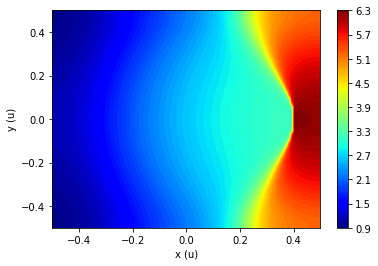

Simulated Dxy2


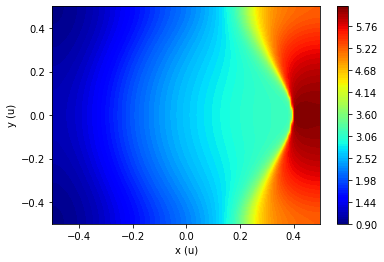

Simulated Dxy1 - Simulated Dxy2 (plot i)


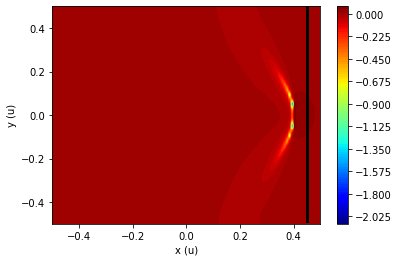

Simulated Dxy1 - Simulated Dxy2 with cutoff 1 (plot i)


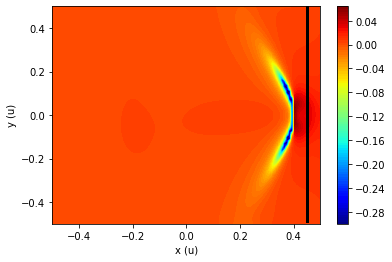

Simulated Dxy1 - Simulated Dxy2 with cutoff 2 (plot i)


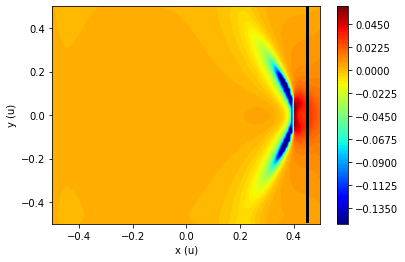

Ideal Dxy1 - Simulated Dxy1 (plot ii)


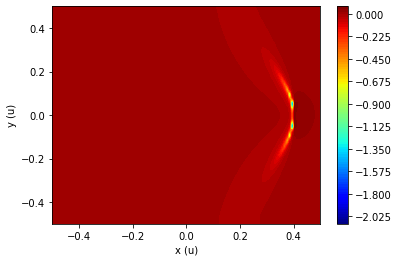

Ideal Dxy1 - Simulated Linecut Dxy1 (plot ii)


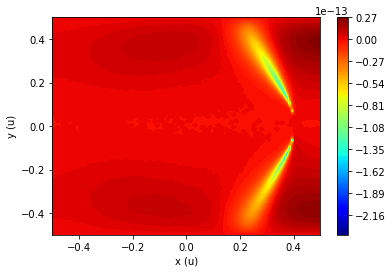

Ideal Dxy1 - Simulated Dxy1 with cutoff 1 (plot ii)


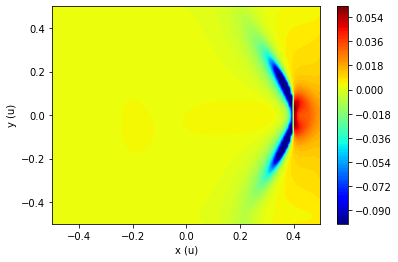

Ideal Dxy1 - Simulated Linecut Dxy1 with cutoff 1 (plot ii)


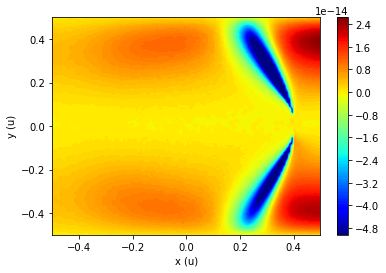

Ideal Dxy1 - Simulated Dxy1 with cutoff 2 (plot ii)


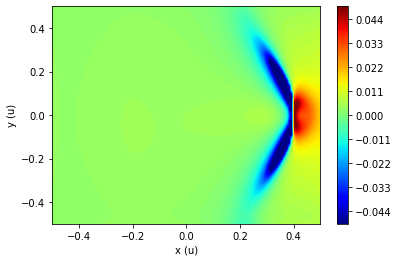

Ideal Dxy1 - Simulated Linecut Dxy1 with cutoff 2 (plot ii)


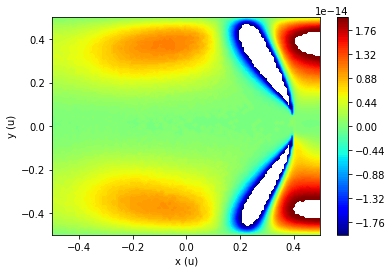

In [5]:
#Version with modified mirror point generator - deletes redundant points within rounding error 
from dolfin import *
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
import matplotlib.patches as patch
from mpl_toolkits.mplot3d import Axes3D
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
from scipy.optimize import curve_fit
import pylab as plt
import cmath

radius = .2

b = 100
depth = 1/b
alpha1 = 1
ktrue = 1000
theta = np.pi/2
omega = 20
n=1
tol = 1E-14
Dx = 1
Dy = 1
Dz = 1
#Set Dxy1 nonzero 
Dxy1 = 0.0000000000001
Dyx1 = - Dxy1
#Set Dxy2 as a near 0 value 
Dxy2 = 0.0000000000001
Dyx2 = - Dxy2
#theta = np.pi/2
truex = 1
truey = 1
truez = 1
xmax = truex/np.sqrt(Dx)
ymax = truey/np.sqrt(Dy)
zmax = truez/np.sqrt(Dz)
xpoints = 105
ypoints = 105
zpoints = 25
e = .1
beta = .89
spacing = truey/(ypoints)
print(spacing)

#coordinates for x-direction dipole center-point (within sample)
heatx = 0.4
heaty = 0
#distance between bewteen dipole charges (along x-axis)
d_x = .02
#sign of dipole charges (hot = 1, cold = -1)
heat_sign_h = 1
heat_sign_c = -1
#How many times to reflect. maxOrder of 1 will only make 4 mirror charges/one reflection
maxOrder = 3
#If a del T = 0 boundary (same sign), True. If a T=0 boundary (flip sign), false
#In the order +x, -x, +y, -y boundaries
types = [True, True, True, True]
A=1
#final diffphase plot cuttoff value 
cut1 = 0.3
cut2 = 0.1

def solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha, Dxy, Dxx, Dyy):
    (ureal, uimag) = TrialFunctions(W)
    (v1, v2) = TestFunctions(W)
    a = (alpha*dot(grad(uimag),grad(v1)) + omega*ureal*v1 + omega*uimag*v2 - alpha*dot(grad(ureal),grad(v2)))*dx + (Dxy/np.sqrt(Dxx*Dyy)*alpha*uimag.dx(1)*v1.dx(0) - Dxy/np.sqrt(Dxx*Dyy)*alpha*uimag.dx(0)*v1.dx(1) - Dxy/np.sqrt(Dxx*Dyy)*alpha*ureal.dx(1)*v2.dx(0) + Dxy/np.sqrt(Dxx*Dyy)*alpha*ureal.dx(0)*v2.dx(1))*dx
    L =  - g*v2*dx
    def bot(x, on_boundary): return on_boundary and near(x[2], -zmax/2, tol)
    noslip = Constant(0.0)
    bc0 = DirichletBC(W.sub(0), noslip, bot)
    bc1 = DirichletBC(W.sub(1), noslip, bot)
    G = Expression('0', degree = 0)
    def boundary(x, on_boundary):
            return on_boundary and not near(x[2], -zmax/2, tol)    
    bcs = [bc0, bc1]
    w = Function(W)
    solve(a == L, w, bcs, solver_parameters={'linear_solver':'mumps'})
    (ureal, uimag) = w.split()
    return ureal, uimag

def phasef(ureal, uimag, xline, yline, depth, z):
    zpoints = len(z)
    wtot = 0
    upointr = 0
    upointi = 0
    for i in range(0,zpoints):
        uliner = ureal(xline,yline,z[i])
        ulinei = uimag(xline,yline,z[i])
        wlayer = np.exp(z[i]/depth)#/ np.sum()
        wtot = wtot + wlayer
        upointr = upointr + uliner*wlayer
        upointi = upointi + ulinei*wlayer
    upointr = upointr/wtot
    upointi = upointi/wtot
    phase = np.arctan2(upointi, upointr)
    return phase

def linepoints(theta, truexc, trueyc, truex, truey, truez, spacing):
    d = 0.0
    listpoints = np.array([[d, truexc, trueyc]])
    lookright = True 
    while lookright:
        d = d+spacing
        xtemp = truexc + np.cos(theta)*d
        ytemp = trueyc + np.sin(theta)*d
        if xtemp > (truex/2 + 0.00000001) or ytemp > (truey/2 + 0.00000001) or xtemp < (-truex/2 - 0.00000001) or ytemp < (-truey/2 - 0.00000001):
            lookright = False
        else:
            listpoints = np.append(listpoints,[[d, xtemp, ytemp]], axis = 0)
    lookleft = True
    d = 0
    while lookleft:
        d = d - spacing
        xtemp = truexc + np.cos(theta)*d
        ytemp = trueyc + np.sin(theta)*d
        #print(ytemp)
        if xtemp > (truex/2 + 0.00000001) or ytemp > (truey/2 + 0.00000001) or xtemp < (-truex/2 - 0.00000001) or ytemp < (-truey/2 - 0.00000001):
            lookleft = False
        else:
            listpoints = np.append([[d, xtemp, ytemp]],listpoints, axis = 0)
    return listpoints

    
def checkradius(radius, truxc, trueyc, truex, truey, x, y):
    if (radius + truexc) > truex/2 or (radius + trueyc) > truey/2 or (radius - truexc) < -truex/2 or (radius - trueyc) < -truey/2:
            radius = min(np.array([truex/2 - truexc, truey/2 - trueyc]))
            print('Radius changed to fall within boundary')
            print('Radius = ' + str(radius))
    rpoints = np.zeros(2)
    xr = np.array([0])
    yr = np.array([0])
    thetal = np.linspace(0, 2*np.pi, 1000)
    for i in range (0, len(thetal)):
        theta = thetal[i]
        xpoint = radius*np.cos(theta) + truexc
        ypoint = radius*np.sin(theta) + trueyc
        xr = np.append(xr, xpoint)
        yr = np.append(yr, ypoint)
    return radius, xr, yr, thetal

def phaseline(ureal, uimag, xline, yline, depth, z):
    phasearray = np.zeros(len(xline))
    for i in range(0, len(xline)):
        phasearray[i] = phasef(ureal, uimag, xline[i], yline[i], depth, z)
    return phasearray
    
def phasecirc(ureal, uimag, xr, yr, depth, z):
    phasearray = np.zeros(len(xr)-1)
    for i in range(1, len(xr)):
        phasearray[i-1] = phasef(ureal, uimag, xr[i], yr[i], depth, z)
    return phasearray

def utotal(cutnumx, cutnumy, x, y, z, zpoints, ureal, uimag, depth): 
    wtot = 0
    utotr = np.zeros(cutnumy*cutnumx)
    utoti = np.zeros(cutnumy*cutnumx)
    for i in range(0,zpoints):
        #print(z[i])
        points = [(x_, y_, z[i]) for x_ in x for y_ in y]
        u_sheetr = np.array([ureal(point) for point in points])
        u_sheeti = np.array([uimag(point) for point in points])
        wlayer = np.exp(z[i]/depth)#/ np.sum()
        wtot = wtot + wlayer
        utotr = utotr + u_sheetr * wlayer
        utoti = utoti + u_sheeti * wlayer
    utotr = utotr/wtot
    utoti = utoti/wtot
    utotr = np.reshape(utotr, (cutnumx, cutnumy))
    utoti = np.reshape(utoti, (cutnumx, cutnumy))
    return utotr, utoti

def Temp_at_point(xc, yc, zc, omega, A, x, y, z):
    r = np.sqrt((x - xc)**2 + (y - yc)**2 + (z - zc)**2)
    T = A/r*exp(-np.sqrt(1j*omega)*r)
    Treal = T.real
    Timag = T.imag
    return Treal, Timag

def Ttotal(cutnumx, cutnumy, x, y, z, cutnumz, xc, yx, zc, depth, sign): 
    #changed zpoints to cutnumz
    wtot = 0
    Ttotr = np.zeros([cutnumy,cutnumx])
    Ttoti = np.zeros([cutnumy,cutnumx])
    for i in range(0,cutnumz):
        T_sheetr = np.zeros([cutnumy,cutnumx])
        T_sheeti = np.zeros([cutnumy,cutnumx])
        for j in range(0,len(x)):
            for k in range(0,len(y)):
                for l in range(0,len(xc)):
                    Trnew, Tinew = Temp_at_point(xc[l], yc[l], zc[l], omega, A, x[j], y[k], z[i])
                    T_sheetr[j,k] = T_sheetr[j,k] + sign[l]*Trnew
                    T_sheeti[j,k] = T_sheeti[j,k] + sign[l]*Tinew
        wlayer = np.exp(z[i]/depth)#/ np.sum()
        wtot = wtot + wlayer
        Ttotr = Ttotr + T_sheetr * wlayer
        Ttoti = Ttoti + T_sheeti * wlayer
    Ttotr = Ttotr/wtot
    Ttoti = Ttoti/wtot
    return Ttotr, Ttoti

def scatter3d(meshpts, u):
    meshpts = mesh.coordinates()
    uarray = np.array([u(Point(x,y,z)) for x,y,z in meshpts])
    #print('uarray')
    #print(uarray)
    xdata = meshpts[:,0]
    xdata = np.transpose(xdata)
    ydata = meshpts[:,1]
    ydata = np.transpose(ydata)
    zdata = meshpts[:,2]
    zdata = np.transpose(zdata)
    cm = plt.get_cmap('jet')
    cNorm = matplotlib.colors.Normalize(vmin=min(uarray), vmax=max(uarray))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(xdata, ydata, zdata, c=scalarMap.to_rgba(uarray))
    scalarMap.set_array(uarray)
    fig.colorbar(scalarMap)
    plt.show()
    
def scatter3dphase(meshpts, uarray):
    meshpts = mesh.coordinates()
    xdata = meshpts[:,0]
    xdata = np.transpose(xdata)
    ydata = meshpts[:,1]
    ydata = np.transpose(ydata)
    zdata = meshpts[:,2]
    zdata = np.transpose(zdata)
    cm = plt.get_cmap('jet')
    cNorm = matplotlib.colors.Normalize(vmin=min(uarray), vmax=max(uarray))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(xdata, ydata, zdata, c=scalarMap.to_rgba(uarray))
    scalarMap.set_array(uarray)
    fig.colorbar(scalarMap)
    plt.show()
    
def scatterT(meshpts, T):
    meshpts = mesh.coordinates()
    xdata = meshpts[:,0]
    xdata = np.transpose(xdata)
    ydata = meshpts[:,1]
    ydata = np.transpose(ydata)
    zdata = meshpts[:,2]
    zdata = np.transpose(zdata)
    cm = plt.get_cmap('jet')
    cNorm = matplotlib.colors.Normalize(vmin=min(T), vmax=max(T))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(xdata, ydata, zdata, c=scalarMap.to_rgba(T))
    scalarMap.set_array(T)
    fig.colorbar(scalarMap)
    plt.show()
    
def Temp_all_mesh(xc, yc, zc, omega, A, meshpts, Tr, Ti, sign):
    #Check if need to scale meshpts by D again
    meshpts = mesh.coordinates()
    xs = meshpts[:,0]
    ys = meshpts[:,1]
    zs = meshpts[:,2]
    for i in range (0, len(meshpts)):
        for j in range (0, len(xc)):
            r = np.sqrt((xs[i] - xc[j])**2 + (ys[i] - yc[j])**2 + (zs[i] - zc[j])**2)
            T = A/r*exp(-np.sqrt(1j*omega)*r)
            Treal = T.real
            Timag = T.imag
            Tr[i] = Tr[i] + sign[j]*Treal
            Ti[i] = Ti[i] + sign[j]*Timag
    return Tr, Ti

#Find a column from a list, used to get the x and y data seperately
def column(matrix, i):
    return [row[i] for row in matrix]

#Reflect over a face listed by side to get new coordinates. Same +x, -x, +y, -y indexing as types
def refFace(x0, y0, x_box, y_box, side):
    if(side == 0):
        newPt = [x_box + (x_box - x0), y0]
    if(side == 1):
        newPt = [-x_box + (-x_box - x0), y0]
    if(side == 2):
        newPt = [x0, y_box + (y_box - y0)]
    if(side == 3):
        newPt = [x0, -y_box + (-y_box - y0)]
    return newPt

#Initialize the list of reflected points with reflections from the base source
#over each boundary
def reflectionStart(x0, y0, x_box, y_box, types):
    refPts = []
    faces = [0, 1, 2, 3]
    order = 1
    refPts.append(refFace(x0, y0, x_box, y_box, 0))
    refPts.append(refFace(x0, y0, x_box, y_box, 1))
    refPts.append(refFace(x0, y0, x_box, y_box, 2))
    refPts.append(refFace(x0, y0, x_box, y_box, 3))
    charges = types
    return refPts, faces, order, charges

#Take a list of reflected charge points and which face they were reflected over most recently
#and reflect those points over all the other faces
def newRefs(Pts, x_box, y_box, faces, order, types, charges):
    xs = column(Pts, 0)
    ys = column(Pts, 1)
    numPts = len(xs)
    refPts = []
    facesNew = []
    chargesNew = []
    order += 1
    for i in range(0, numPts):
        for j in range(0, 4):
            if(j != faces[i]):
                refPts.append(refFace(xs[i], ys[i], x_box, y_box, j))
                facesNew.append(j)
                if(types[j] == True):
                    charge = charges[i]
                else:
                    charge = not charges[i]
                chargesNew.append(charge)
    return refPts, facesNew, order, chargesNew

#Call newRefs repeatedly to make a full list of all the reflected points
def makeRefs(x_0, y_0, x_box, y_box, maxOrder, types):
    RefPts, faces, order, charges = reflectionStart(x_0, y_0, x_box, y_box, types)
    AllRefs = RefPts
    Allfaces = faces
    Allords = [order]*len(faces)
    AllCharges = charges
    while(order < maxOrder):
        RefPts, faces, order, charges = newRefs(RefPts, x_box, y_box, faces, order, types, charges)
        for i in range(len(RefPts)):
            AllRefs.append(RefPts[i])
            Allfaces.append(faces[i])
            Allords.append(order)
            AllCharges.append(charges[i])
        AllRefs, Allfaces, Allords, AllCharges = deleteRedundant(AllRefs, Allfaces, Allords, AllCharges)
    return AllRefs, Allfaces, Allords, AllCharges     

#Get rid of redundant points
def deleteRedundant(AllRefs, Allfaces, Allords, AllCharges):
    look = True
    i = 0
    while(look):
        Keep = [True]*len(AllRefs)
        for j in range(len(AllRefs)):
            pj = AllRefs[j]
            xj = pj[0]
            yj = pj[1]
            pI = AllRefs[i]
            xI = pI[0]
            yI = pI[1]
            dist = np.sqrt((xI - xj)**2 + (yI - yj)**2)
            if dist < 0.0001:
                if dist > 0:
                    print('dist in delete redundant')
                    print(dist)
                    print('Deleting point')
                    print(AllRefs[j])
                    print('Because same as point')
                    print(AllRefs[i])
                samebool = (j == i)
                if(not samebool):
                    Keep[j] = False
        AllRefs = [b for a, b in zip(Keep, AllRefs) if a]
        Allfaces = [b for a, b in zip(Keep, Allfaces) if a]
        Allords = [b for a, b in zip(Keep, Allords) if a]
        AllCharges = [b for a, b in zip(Keep, AllCharges) if a]
        i += 1
        if(i >= len(AllRefs)):
            look = False
    return AllRefs, Allfaces, Allords, AllCharges

#Get rid of base point if it appeared as a reflection
def deleteBase(AllRefs, Allfaces, Allords, AllCharges, x0, y0):
    Keep = [True]*len(AllRefs)
    for j in range(len(AllRefs)):
        #if(AllRefs[j] == [x0, y0]):
        pj = AllRefs[j]
        xj = pj[0]
        yj = pj[1]
        dist = np.sqrt((xj - x0)**2 + (yj - y0)**2)
        if dist < 0.0001:
            Keep[j] = False
            #if dist > 0:
            print('dist in delete base')
            print(dist)
            if dist > 0:
                print('Deleting point')
                print(AllRefs[j])
                print('Because same as point')
                print([x0, y0])
    AllRefs = [b for a, b in zip(Keep, AllRefs) if a]
    Allfaces = [b for a, b in zip(Keep, Allfaces) if a]
    Allords = [b for a, b in zip(Keep, Allords) if a]
    AllCharges = [b for a, b in zip(Keep, AllCharges) if a]
    return AllRefs, Allfaces, Allords, AllCharges

def basePhase(x, y, x_0, y_0, Dx, Dy, omega):
    r = np.sqrt((x - x_0)**2/Dx + (y - y_0)**2/Dy)
    ph = -np.sqrt(omega/2)*r
    return ph
#print('Running...')

#x-coordinates of x-direction dipole heat sources
heatxh = heatx + d_x/2
heatxc = heatx - d_x/2
mirrorx = xmax - heatx
#x-coordinates of x-direction dipole mirror charges
mirrorxh = mirrorx + d_x/2
mirrorxc = mirrorx - d_x/2
#Length and Width of the box centered at (0,0)
x_box = xmax/2
y_box = ymax/2
#heatz = same for all mirror points
heatz = zmax/2
#include y-direction dipole mirror charges to model Dxy term
d_y1 = 2*Dxy1/Dx * d_x
d_y2 = 2*Dxy2/Dx * d_x
#centerpoint of y-dipole (same as centerpoint of mirror x-direction dipole)
mir_y = heaty
mir_x = mirrorx
#y-coordinates of y-direction mirror charges
mir_yh1 = heaty + d_y1/2
mir_yc1 = heaty - d_y1/2
#mir_yh2 = heaty + d_y2/2
#mir_yc2 = heaty - d_y2/2
sample_x = [heatxh, heatxc]
sample_y = [heaty, heaty]
sample_sign = [heat_sign_h, heat_sign_c]

ydip_x = [mirrorx, mirrorx]
ydip_y1 = [mir_yh1, mir_yc1]
#ydip_y2 = [mir_yh2, mir_yc2]
ydip_sign = [heat_sign_h, heat_sign_c]

#Coordinates of the base heat source
x_0 = sample_x
y_0 = sample_y

#Find the location of all the reflections, then delete redundant points
#Also return which face was reflected over to get each point, how many reflections were
#done to get each point, and the sign of that mirror charge (True is same sign as original)
AllRefs = list()
Allfaces = list()
Allords = list()
AllCharges = list()
signmirror = list()

for i in range(0,len(sample_x)):
    AllRefs1, Allfaces, Allords1, AllCharges1 = makeRefs(x_0[i], y_0[i], x_box, y_box, maxOrder, types)
    signs1 = np.zeros(len(AllRefs1))
    signs1 = signs1 + sample_sign[i]
    signmirror.extend(signs1)
    AllRefs.extend(AllRefs1)
    Allords.extend(Allords1)
    AllCharges.extend(AllCharges1)
    AllRefs, Allfaces, Allords, AllCharges = deleteRedundant(AllRefs, Allfaces, Allords, AllCharges)
    AllRefs, Allfaces, Allords, AllCharges = deleteBase(AllRefs, Allfaces, Allords, AllCharges, x_0[i], y_0[i])
    
#Plot the pont locations and a rectangle showing where your box is
#figure, ax = plt.subplots(1)
#ax.scatter(x_0, y_0)
#ax.scatter(ydip_x, ydip_y)
#AllXs = column(AllRefs, 0)
#AllYs = column(AllRefs, 1)
#ax.scatter(AllXs, AllYs)
#rect = patch.Rectangle((-x_box, -y_box), 2*x_box, 2*y_box, fill=False, linewidth=2.5)
#ax.add_patch(rect)
#plt.show()

#Print out the points, how many reflections were needed to get there
#And if they are the same sign or opposite sign as the original source
print('Coordinates of Reflected Point')
print(AllRefs)
#print('Order of reflection')
#print(Allords)
#print('Charge Type')
#print(signmirror)

#Same plotting, but now different color for different sign of charges
#figure, ax = plt.subplots(1)
#ax.scatter(x_0, y_0)
#ax.scatter(ydip_x, ydip_y)
#posXs = [b for a, b in zip(AllCharges, AllXs) if a]
#posYs = [b for a, b in zip(AllCharges, AllYs) if a]
#negXs = [b for a, b in zip(AllCharges, AllXs) if not a]
#negYs = [b for a, b in zip(AllCharges, AllYs) if not a]
#ax.scatter(posXs, posYs)
#ax.scatter(negXs, negYs)
#rect = patch.Rectangle((-x_box, -y_box), 2*x_box, 2*y_box, fill=False, linewidth=2.5)
#ax.add_patch(rect)
#plt.show()

xmirror = column(AllRefs,0)
xc = sample_x
xc.extend(xmirror)
xc.extend(ydip_x)
ymirror = column(AllRefs,1)
yc = sample_y
yc.extend(ymirror)
yc.extend(ydip_y1)
#yc2 = sample_y
#yc2.extend(ymirror)
#yc2.extend(ydip_y2)
        
sign = sample_sign
sign.extend(signmirror)
sign.extend(ydip_sign)

xc = xc/np.sqrt(Dx)
yc = yc/np.sqrt(Dy)
#yc2 = yc2/np.sqrt(Dy)
zc = np.zeros(len(xc))
for i in range(0,len(zc)):
    zc[i] = heatz

print('Running...')

#plot different color depending on sign of charge
xchot = list()
ychot1 = list()
#ychot2 = list()
xccold = list()
yccold1 = list()
#yccold2 = list()
for i in range(0,len(sign)):
    if sign[i] == 1:
        xchot.extend([xc[i]])
        ychot1.extend([yc[i]])
        #ychot2.extend([yc2[i]])
    else:
        xccold.extend([xc[i]])
        yccold1.extend([yc[i]])
        #yccold2.extend([yc2[i]])

figure, ax = plt.subplots(1)
ax.scatter(xchot, ychot1, c = 'red')
ax.scatter(xccold, yccold1, c = 'blue')
rect = patch.Rectangle((-x_box, -y_box), 2*x_box, 2*y_box, fill=False, linewidth=2.5)
ax.add_patch(rect)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Top View of All Charges for Ideal Solution (Dxy1)')
plt.show()

density = (xpoints*ypoints*zpoints)/(truex*truey*truez)

p0 = Point (-xmax/2, -ymax/2, -zmax/2)
p1 = Point (xmax/2, ymax/2, zmax/2)
mesh = BoxMesh(p0, p1, xpoints, ypoints, zpoints)

CG1_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
CG2_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
W_elem = MixedElement([CG1_elem, CG2_elem])
W = FunctionSpace(mesh, W_elem)
  
kx = ktrue*Dx
ky = ktrue*Dy

if sign[0] == 1:
    if sign[1] == 1:
        g = Expression('exp(b*(x[2] - top/2) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter)) + exp(b*(x[2] - top/2) - kx*(x[0]-xcenter2)*(x[0]-xcenter2) - ky*(x[1]-ycenter2)*(x[1]-ycenter2))', degree = 2, kx = kx, ky = ky, b = b*np.sqrt(Dz), top = zmax/2, xcenter = xc[0], ycenter = yc[0], xcenter2 = xc[1], ycenter2 = yc[1])
    if sign[1] == -1:
        g = Expression('exp(b*(x[2] - top/2) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter)) - exp(b*(x[2] - top/2) - kx*(x[0]-xcenter2)*(x[0]-xcenter2) - ky*(x[1]-ycenter2)*(x[1]-ycenter2))', degree = 2, kx = kx, ky = ky, b = b*np.sqrt(Dz), top = zmax/2, xcenter = xc[0], ycenter = yc[0], xcenter2 = xc[1], ycenter2 = yc[1])
if sign[0] == -1:
    if sign[1] == 1:
        g = Expression('- exp(b*(x[2] - top/2) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter)) + exp(b*(x[2] - top/2) - kx*(x[0]-xcenter2)*(x[0]-xcenter2) - ky*(x[1]-ycenter2)*(x[1]-ycenter2))', degree = 2, kx = kx, ky = ky, b = b*np.sqrt(Dz), top = zmax/2, xcenter = xc[0], ycenter = yc[0], xcenter2 = xc[1], ycenter2 = yc[1])
    if sign[1] == -1: 
        g = Expression('- exp(b*(x[2] - top/2) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter)) - exp(b*(x[2] - top/2) - kx*(x[0]-xcenter2)*(x[0]-xcenter2) - ky*(x[1]-ycenter2)*(x[1]-ycenter2))', degree = 2, kx = kx, ky = ky, b = b*np.sqrt(Dz), top = zmax/2, xcenter = xc[0], ycenter = yc[0], xcenter2 = xc[1], ycenter2 = yc[1])

ureal1, uimag1 = solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha1, Dxy1, Dx, Dy)

print('Still running...')

ureal2, uimag2 = solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha1, Dxy2, Dx, Dy)

#print('Still running...')

meshpts = mesh.coordinates()
meshpts[:, 0] *= np.sqrt(Dx)
meshpts[:, 1] *= np.sqrt(Dy)
meshpts[:, 2] *= np.sqrt(Dz)

#Tr = np.zeros(len(meshpts))  
#Ti = np.zeros(len(meshpts))      
#Tr, Ti = Temp_all_mesh(xc, yc, zc, omega, A, meshpts, Tr, Ti, sign)

#Tphase = np.arctan2(Ti, Tr)

cutnumy = xpoints+1
cutnumx = ypoints+1
cutnumz = zpoints+1

xn = -truex/2
xp = truex/2
zn = -truez/2
zp = truez/2
yp = truey/2
yn = -truey/2

y = np.linspace(yn + tol, yp - tol, cutnumy)
x = np.linspace(xn + tol, xp - tol, cutnumx)
z = np.linspace(zn + tol, zp - tol, cutnumz)

utotr1, utoti1 = utotal(cutnumx, cutnumy, x, y, z, cutnumz, ureal1, uimag1, depth)
utotr2, utoti2 = utotal(cutnumx, cutnumy, x, y, z, zpoints, ureal2, uimag2, depth)

#print('Ideal Real')
#scatterT(meshpts, Tr)

#print('Sim Real (Dxy = -Dyx = ' + str(Dxy1) + ')')
#scatter3d(meshpts, ureal1)

#print('Real 2 (Dxy = -Dyx = ' + str(Dxy2) + ')')
#scatter3d(meshpts, ureal2)

#print('Ideal Imaginary')
#scatterT(meshpts, Ti)

#print('Sim Imaginary (Dxy = -Dyx = ' + str(Dxy1) + ')')
#scatter3d(meshpts, uimag1)

#print('Imaginary 2 (Dxy = -Dyx = ' + str(Dxy2) + ')')
#scatter3d(meshpts, uimag2)

Tr2d, Ti2d = Ttotal(cutnumx, cutnumy, x, y, z, cutnumz, xc, yc, zc, depth, sign)
#print('Ideal Real 2D')
#plt.imshow(Tr2d, cmap = cmx.jet)
#plt.colorbar()
#plt.xlabel('y (points)')
#plt.ylabel('x (points)')
#plt.figure()
#plt.show()

#print('Sim Real 2D (Dxy = -Dyx = ' + str(Dxy1) + ')')
#plt.imshow(utotr1, cmap = cmx.jet)
#plt.colorbar()
#plt.title('Real Part (Dxy = -Dyx = ' + str(Dxy1) + ')')
#plt.xlabel('y (points)')
#plt.ylabel('x (points)')
#plt.figure()
#plt.show()

#print('Real 2D 2 (Dxy = -Dyx = ' + str(Dxy2) + ')')
#plt.imshow(utotr2, cmap = cmx.jet)
#plt.colorbar()
#plt.title('Real Part (Dxy = -Dyx = ' + str(Dxy2) + ')')
#plt.xlabel('y (points)')
#plt.ylabel('x (points)')
#plt.figure()
#plt.show()

#print('Ideal Imaginary 2D')
#plt.imshow(Ti2d, cmap = cmx.jet)
#plt.colorbar()
#plt.xlabel('y (points)')
#plt.ylabel('x (points)')
#plt.figure()
#plt.show()

#print('Sim Imaginary 2D (Dxy = -Dyx = ' + str(Dxy1) + ')')
#plt.imshow(utoti1, cmap = cmx.jet)
#plt.colorbar()
#plt.title('Imaginary Part (Dxy = -Dyx = ' + str(Dxy1) + ')')
#plt.xlabel('y (points)')
#plt.ylabel('x (points)')
#plt.figure()
#plt.show()

#print('Imaginary 2D 2 (Dxy = -Dyx = ' + str(Dxy2) + ')')
#plt.imshow(utoti2, cmap = cmx.jet)
#plt.colorbar()
#plt.title('Imaginary Part (Dxy = -Dyx = ' + str(Dxy2) + ')')
#plt.xlabel('y (points)')
#plt.ylabel('x (points)')
#plt.figure()
#plt.show()

tan1 = np.arctan2(utoti1, utotr1)
print('tan1.shape')
print(tan1.shape)
tan2 = np.arctan2(utoti2, utotr2)

firstdiff = unwrap_phase(np.transpose(tan1 - tan2))

tans = np.transpose(tan1-tan2)
tansh = tans.shape
for i in range(0,tansh[0]):
    for j in range(0,tansh[1]):
        if tans[i,j] > cut1:
            tans[i,j] = cut1
        if tans[i,j] < -cut1:
            tans[i,j] = -cut1

#print('Simulated Dxy1 - Simulated Dxy2 (before unwrapping)')
#xv, yv = np.meshgrid(x, y)
#fig = plt.gcf()
#plt.contourf(xv, yv, np.transpose(tan1 - tan2), 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
#plt.colorbar()
#plt.title('Sim Phase 2D (Dxy = -Dyx = 0)')
#plt.xlabel('x')
#plt.ylabel('y')
#plt.show()
#print('Simulated Dxy1 - Simulated Dxy2 (before unwrapping with cutoff)')
#xv, yv = np.meshgrid(x, y)
#fig = plt.gcf()
#plt.contourf(xv, yv, tans, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
#plt.colorbar()
#plt.title('Sim Phase 2D (Dxy = -Dyx = 0)')
#plt.xlabel('x')
#plt.ylabel('y')
#plt.show()

#print('Simulated Dxy1 - Simulated Dxy2 (after first unwrapping)')
#xv, yv = np.meshgrid(x, y)
#fig = plt.gcf()
#plt.contourf(xv, yv, firstdiff, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
#plt.colorbar()
#plt.title('Sim Phase 2D (Dxy = -Dyx = 0)')
#plt.xlabel('x')
#plt.ylabel('y')
#plt.show()

#print('Phase Plots')

#print('Ideal Phase on Mesh')
#scatterT(meshpts, Tphase)
#Tphase_un = unwrap_phase(Tphase)
#print('Ideal Phase on Mesh Unwrapped')
#scatterT(meshpts, Tphase_un)

#print('Sim Phase on Mesh')
#Simag = np.array([uimag1(Point(x,y,z)) for x,y,z in meshpts])
#Sreal = np.array([ureal1(Point(x,y,z)) for x,y,z in meshpts])

#Sphase = np.arctan2(Simag, Sreal)
#scatter3dphase(meshpts, Sphase)

Tphase2d = np.arctan2(Ti2d, Tr2d)

xv, yv = np.meshgrid(x, y)
#fig = plt.gcf()
#plt.contourf(xv, yv, np.transpose(Tphase2d), 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
#plt.colorbar()
#plt.title('Ideal Phase 2D')
#plt.xlabel('x')
#plt.ylabel('y')
#plt.show()

#plt.imshow(tan1, cmap = cmx.jet)
#plt.colorbar()
#plt.title('Phase')
#plt.xlabel('y (points)')
#plt.ylabel('x (points)')
#plt.figure()
#plt.show()
testline = linepoints(theta, xmax/2, ymax/2, truex, truey, truez, spacing)
#distance = testline[:, 0]
xline = testline[:, 1]
#print('xline')
#print(xline)
yline = testline[:, 2]
ph1 = np.zeros([len(x),len(yline)])
print('ph1.shape')
print(ph1.shape)
ph2 = np.zeros([len(x),len(yline)])
print('len(yline)')
print(len(yline))
#print('yline')
#print(yline)
#print('y')
#print(y)
for i in range(0,len(x)):
    #print('x[i]')
    #print(x[i])
    testline = linepoints(theta, x[i], ymax/2, truex, truey, truez, spacing)
    distance = testline[:, 0]
    xline = testline[:, 1]
    yline = testline[:, 2]
    #print('len(yline)')
    #print(len(yline))
    phasearray1 = phaseline(ureal1, uimag1, xline, yline, depth, z)
    #print('phasarray1')
    #print(phasearray1)
    #print('len(phasearray1)')
    #print(len(phasearray1))
    ph1[i,:] = phasearray1
    #print('ph1')
    #print(ph1)
    phasearray2 = phaseline(ureal2, uimag2, xline, yline, depth, z)
    ph2[i,:] = phasearray2
    
testline = linepoints(theta, .45, ymax/2, truex, truey, truez, spacing)
distance = testline[:, 0]
xline = testline[:, 1]
yline = testline[:, 2]


print('Multiple linecut plots (like omega sweep but over full lattice):')

print('ph1 (multiple linecuts with Dxy1) plot')
x1, y1 = np.meshgrid(x, yline)
print(len(x1))
print(len(y1))
fig = plt.gcf()
plt.contourf(x1, y1, np.transpose(ph1), 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Sim Phase 2D (Dxy = -Dyx = 0)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print('unwrapped ph1 plot')
x1, y1 = np.meshgrid(x, yline)
fig = plt.gcf()
plt.contourf(x1, y1, unwrap_phase(np.transpose(ph1)), 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Sim Phase 2D (Dxy = -Dyx = 0)')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0,dx=0.02,linecut_plots_compare_with_lattice_plots/SimPhase_Linecut.pdf')
plt.show()

print('ph2 (multiple linecutes with Dxy2) plot')
x1, y1 = np.meshgrid(x, yline)
fig = plt.gcf()
plt.contourf(x1, y1, np.transpose(ph2), 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Sim Phase 2D (Dxy = -Dyx = 0)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print('unwrapped ph2 plot')
x1, y1 = np.meshgrid(x, yline)
fig = plt.gcf()
plt.contourf(x1, y1, unwrap_phase(np.transpose(ph2)), 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Sim Phase 2D (Dxy = -Dyx = 0)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

phdif = np.transpose(ph1 - ph2)
unwrapped_phdif = unwrap_phase(phdif)


print('phdif plot')
x1, y1 = np.meshgrid(x, yline)
fig = plt.gcf()
plt.contourf(x1, y1, phdif, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Sim Phase 2D (Dxy = -Dyx = 0)')
plt.xlabel('x')
plt.ylabel('y')
#plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,dx=0.02,del_within_tol_cutoff_plots/plotii2.pdf')
plt.show()

print('unwrapped phdif plot')
x1, y1 = np.meshgrid(x, yline)
fig = plt.gcf()
plt.contourf(x1, y1, unwrapped_phdif, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Sim Phase 2D (Dxy = -Dyx = 0)')
plt.xlabel('x')
plt.ylabel('y')
#plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,dx=0.02,linecut_plots/phdif.pdf')
plt.show()

unwrapped_phdif_sh = unwrapped_phdif.shape
for i in range(0,unwrapped_phdif_sh[0]):
    for j in range(0,unwrapped_phdif_sh[1]):
        if unwrapped_phdif[i,j] > .02:
            unwrapped_phdif[i,j] = .02
        if unwrapped_phdif[i,j] < -.02:
            unwrapped_phdif[i,j] = -.02
            
print('unwrapped phdif plot with cutoff 1')
x1, y1 = np.meshgrid(x, yline)
fig = plt.gcf()
plt.contourf(x1, y1, unwrapped_phdif, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Sim Phase 2D (Dxy = -Dyx = 0)')
plt.xlabel('x')
plt.ylabel('y')
#plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,dx=0.02,linecut_plots/cutoff1.pdf')
plt.show()

unwrapped_phdif_sh = unwrapped_phdif.shape
for i in range(0,unwrapped_phdif_sh[0]):
    for j in range(0,unwrapped_phdif_sh[1]):
        if unwrapped_phdif[i,j] > .01:
            unwrapped_phdif[i,j] = .01
        if unwrapped_phdif[i,j] < -.01:
            unwrapped_phdif[i,j] = -.01
            
print('unwrapped phdif plot with cutoff 2')
x1, y1 = np.meshgrid(x, yline)
fig = plt.gcf()
plt.contourf(x1, y1, unwrapped_phdif, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Sim Phase 2D (Dxy = -Dyx = 0)')
plt.xlabel('x')
plt.ylabel('y')
#plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,dx=0.02,linecut_plots/cutoff2.pdf')
plt.show()

unwrapped_phdif_sh = unwrapped_phdif.shape
for i in range(0,unwrapped_phdif_sh[0]):
    for j in range(0,unwrapped_phdif_sh[1]):
        if unwrapped_phdif[i,j] > .005:
            unwrapped_phdif[i,j] = .005
        if unwrapped_phdif[i,j] < -.005:
            unwrapped_phdif[i,j] = -.005
            
print('unwrapped phdif plot with cutoff 3')
x1, y1 = np.meshgrid(x, yline)
fig = plt.gcf()
plt.contourf(x1, y1, unwrapped_phdif, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Sim Phase 2D (Dxy = -Dyx = 0)')
plt.xlabel('x')
plt.ylabel('y')
#plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,dx=0.02,linecut_plots/cutoff3.pdf')
plt.show()

#fig = plt.gcf()
#plt.contourf(xv, yv, np.transpose(tan2), 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
#plt.colorbar()
#plt.title('Phase 2 (Dxy = -Dyx = ' + str(Dxy2) + ')')
#plt.xlabel('x')
#plt.ylabel('y')
#plt.show()

testline = linepoints(theta, .45, 0, truex, truey, truez, spacing)
distance = testline[:, 0]
xline = testline[:, 1]
yline = testline[:, 2]
phasearray1 = phaseline(ureal1, uimag1, xline, yline, depth, z)
phasearray2 = phaseline(ureal2, uimag2, xline, yline, depth, z)

print('Linecuts at x = 0.45 (value used in omega sweep)')

plt.scatter(distance, phasearray1, c = 'black')
plt.scatter(distance, phasearray2, c = 'red')
plt.title('Simulated Phase vs Position')
plt.xlabel('Distance')
plt.ylabel('Phase')
plt.show()

plt.scatter(distance, phasearray1 - phasearray2, c = 'black')
#plt.scatter(distance, phasearray2, c = 'red')
plt.title('Simulated Dxy1 - Dxy2 vs Position')
plt.xlabel('Distance')
plt.ylabel('Phase Difference')
plt.show()

print('Full lattice solve plots:')

print('Ideal Dxy1')
ideal_unwrapped1 = unwrap_phase(np.transpose(Tphase2d))
fig = plt.gcf()
plt.contourf(xv, yv, ideal_unwrapped1, 100, cmap = cmx.jet)
plt.colorbar()
#plt.title('Mirror Charge Phase')
plt.xlabel('x (u)')
plt.ylabel('y (u)')
#plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,dx=0.02,del_within_tol_cutoff_plots/MirPhase.pdf')
plt.show()

image_unwrapped1 = unwrap_phase(np.transpose(tan1))
image_unwrapped2 = unwrap_phase(np.transpose(tan2))

print('Simulated Dxy1')
fig = plt.gcf()
plt.contourf(xv, yv, image_unwrapped1, 100, cmap = cmx.jet)
plt.colorbar()
#plt.title('Simulated Phase')
plt.xlabel('x (u)')
plt.ylabel('y (u)')
plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0,dx=0.02,linecut_plots_compare_with_lattice_plots/SimPhase_whole_lattice.pdf')
plt.show()

print('Simulated Dxy2')
fig = plt.gcf()
plt.contourf(xv, yv, image_unwrapped2, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Simulated Phase')
plt.xlabel('x (u)')
plt.ylabel('y (u)')
#plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,dx=0.02,del_within_tol_cutoff_plots/SimPhase.pdf')
plt.show()
#image_unwrapped = unwrap_phase(phasen)

imax1 = max(image_unwrapped1.max(axis = 1))
#print(imax1)
n = np.abs(imax1)//(np.pi*2)*np.sign(imax1)
#print(n)
image_unwrapped1 = image_unwrapped1 - 2*np.pi*n

imax2 = max(image_unwrapped2.max(axis = 1))
#print(imax1)
n = np.abs(imax2)//(np.pi*2)*np.sign(imax2)
#print(n)
image_unwrapped2 = image_unwrapped2 - 2*np.pi*n

imax2 = max(ideal_unwrapped1.max(axis = 1))
#print(imax2)
n = np.abs(imax2)//(np.pi*2)*np.sign(imax2)
#print(n)
ideal_unwrapped1 = ideal_unwrapped1 - 2*np.pi*n


#diffphase = ideal_unwrapped1 - image_unwrapped1
diffphase = unwrap_phase(np.transpose(tan1 - tan2))
diffphase_l = unwrap_phase(np.transpose(tan1 - ph1))
diffsim = image_unwrapped1 - image_unwrapped2
#diffphase = image_unwrapped1 - ideal_unwrapped1
#fig = plt.gcf()
#plt.contourf(xv, yv, diffphase, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
#plt.colorbar()
#plt.title('Ideal Phase - Sim Phase')
#plt.xlabel('x')
#plt.ylabel('y')
#plt.show()

imax = max(diffphase.max(axis = 1))
#print(imax)
n = np.abs(imax)//(np.pi*2)*np.sign(imax)
#print(n)
diffphase = diffphase - 2*np.pi*n

imax = max(diffphase_l.max(axis = 1))
#print(imax)
n = np.abs(imax)//(np.pi*2)*np.sign(imax)
#print(n)
diffphase_l = diffphase_l - 2*np.pi*n

imax = max(diffsim.max(axis = 1))
#print(imax)
n = np.abs(imax)//(np.pi*2)*np.sign(imax)
#print(n)
diffsim = diffsim - 2*np.pi*n

print('Simulated Dxy1 - Simulated Dxy2 (plot i)')
fig = plt.gcf()
plt.contourf(xv, yv, diffsim, 100, cmap = cmx.jet)
plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Mirror Charge Phase - Simulated Phase')
plt.xlabel('x (u)')
plt.ylabel('y (u)')
#plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,dx=0.02,del_within_tol_cutoff_plots/ploti.pdf')
plt.show()

diffsimsh = diffsim.shape
for i in range(0,diffsimsh[0]):
    for j in range(0,diffsimsh[1]):
        if diffsim[i,j] > cut1:
            diffsim[i,j] = cut1
        if diffsim[i,j] < -cut1:
            diffsim[i,j] = -cut1
            
print('Simulated Dxy1 - Simulated Dxy2 with cutoff 1 (plot i)')            
fig = plt.gcf()
plt.contourf(xv, yv, diffsim, 100, cmap = cmx.jet)
plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Mirror Charge Phase - Simulated Phase')
plt.xlabel('x (u)')
plt.ylabel('y (u)')
#plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,dx=0.02,del_within_tol_cutoff_plots/ploti1.pdf')
plt.show()

for i in range(0,diffsimsh[0]):
    for j in range(0,diffsimsh[1]):
        if diffsim[i,j] > cut1/2:
            diffsim[i,j] = cut1/2
        if diffsim[i,j] < -cut1/2:
            diffsim[i,j] = -cut1/2
            
print('Simulated Dxy1 - Simulated Dxy2 with cutoff 2 (plot i)')            
fig = plt.gcf()
plt.contourf(xv, yv, diffsim, 100, cmap = cmx.jet)
plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Mirror Charge Phase - Simulated Phase')
plt.xlabel('x (u)')
plt.ylabel('y (u)')
#plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,dx=0.02,del_within_tol_cutoff_plots/ploti2.pdf')
plt.show()

print('Ideal Dxy1 - Simulated Dxy1 (plot ii)')
fig = plt.gcf()
plt.contourf(xv, yv, diffphase, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Mirror Charge Phase - Simulated Phase')
plt.xlabel('x (u)')
plt.ylabel('y (u)')
plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0,dx=0.02,linecut_plots_compare_with_lattice_plots/Ideal-Sim=Error.pdf')
plt.show()

print('Ideal Dxy1 - Simulated Linecut Dxy1 (plot ii)')
fig = plt.gcf()
plt.contourf(xv, yv, diffphase_l, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Mirror Charge Phase - Simulated Phase')
plt.xlabel('x (u)')
plt.ylabel('y (u)')
plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0,dx=0.02,linecut_plots_compare_with_lattice_plots/Ideal-Sim_Linecut=Linecut_Error.pdf')
plt.show()

diffsh = diffphase.shape
for i in range(0,diffsh[0]):
    for j in range(0,diffsh[1]):
        if diffphase[i,j] > cut2:
            diffphase[i,j] = cut2
        if diffphase[i,j] < -cut2:
            diffphase[i,j] = -cut2
            
diffsh_l = diffphase_l.shape
for i in range(0,diffsh_l[0]):
    for j in range(0,diffsh_l[1]):
        if diffphase_l[i,j] > .5*10**(-13):
            diffphase_l[i,j] = .5*10**(-13)
        if diffphase_l[i,j] < -.5*10**(-13):
            diffphase_l[i,j] = -.5*10**(-13)
            
print('Ideal Dxy1 - Simulated Dxy1 with cutoff 1 (plot ii)')            
fig = plt.gcf()
plt.contourf(xv, yv, diffphase, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Mirror Charge Phase - Simulated Phase')
plt.xlabel('x (u)')
plt.ylabel('y (u)')
#plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,dx=0.02,del_within_tol_cutoff_plots/plotii1.pdf')
plt.show()

print('Ideal Dxy1 - Simulated Linecut Dxy1 with cutoff 1 (plot ii)')            
fig = plt.gcf()
plt.contourf(xv, yv, diffphase_l, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Mirror Charge Phase - Simulated Phase')
plt.xlabel('x (u)')
plt.ylabel('y (u)')
#plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,dx=0.02,del_within_tol_cutoff_plots/plotii1.pdf')
plt.show()

#diffsh = diffphase.shape
for i in range(0,diffsh[0]):
    for j in range(0,diffsh[1]):
        if diffphase[i,j] > cut2/2:
            diffphase[i,j] = cut2/2
        if diffphase[i,j] < -cut2/2:
            diffphase[i,j] = -cut2/2
            
for i in range(0,diffsh_l[0]):
    for j in range(0,diffsh_l[1]):
        if diffphase_l[i,j] > .2*10**(-13):
            diffphase_l[i,j] = .2*10**(-13)
        if diffphase_l[i,j] < -.2*10**(-13):
            diffphase_l[i,j] = -.2*10**(-13)
            
print('Ideal Dxy1 - Simulated Dxy1 with cutoff 2 (plot ii)')           
fig = plt.gcf()
plt.contourf(xv, yv, diffphase, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Mirror Charge Phase - Simulated Phase')
plt.xlabel('x (u)')
plt.ylabel('y (u)')
#plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,dx=0.02,del_within_tol_cutoff_plots/plotii2.pdf')
plt.show()

print('Ideal Dxy1 - Simulated Linecut Dxy1 with cutoff 2 (plot ii)')           
fig = plt.gcf()
plt.contourf(xv, yv, diffphase_l, 100, cmap = cmx.jet)
#plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
#plt.title('Mirror Charge Phase - Simulated Phase')
plt.xlabel('x (u)')
plt.ylabel('y (u)')
#plt.savefig('/Users/tiffanypaul/Desktop/ErikFiles_2020/New_stuff_(2020)/Dxy_code /dipole_simulation/Dxy=0.01,dx=0.02,del_within_tol_cutoff_plots/plotii2.pdf')
plt.show()
